In [31]:
import pandas as pd
import datetime
from datetime import datetime as dt
btc_usd_df = pd.read_csv('../BTC-USD.csv')
btc_usd_df = btc_usd_df.reset_index()
btc_usd_df = btc_usd_df.rename(columns={'index': 'key'})
btc_usd_df.columns = btc_usd_df.columns.str.lower()
K_DEFAULT_DT_FMT = "%Y-%m-%d"
def week_of_date(date_str, fmt=K_DEFAULT_DT_FMT):
    """
    输入'2016-01-01' 转换为星期几，返回int 0-6分别代表周一到周日
    :param date_str: 式时间日期str对象
    :param fmt: 如date_str不是%Y-%m-%d形式，对应的格式str对象
    :param fix: 是否修复日期不规范的写法，eg. 2016-1-1 fix 2016-01-01
    :return: 返回int 0-6分别代表周一到周日
    """
    return dt.strptime(date_str, fmt).weekday()
    

btc_usd_df['date'] = btc_usd_df.apply(lambda row: datetime.datetime.strptime(row['date'], '%Y-%m-%d'), axis=1)
btc_usd_df['date_week'] = btc_usd_df['date'].apply(lambda x: week_of_date(str(x), '%Y-%m-%d %H:%M:%S'))
btc_usd_df = btc_usd_df.set_index('date')
btc_usd_df.tail()

# standarlize data, index as close_date, all lower case

,key,open,high,low,close,adj close,volume,date_week
date,,,,,,,,
2024-01-25,1485,40075.550781,40254.480469,39545.664062,39933.808594,39933.808594,18491782013,3
2024-01-26,1486,39936.816406,42209.386719,39825.691406,41816.871094,41816.871094,25598119893,4
2024-01-27,1487,41815.625000,42195.632812,41431.281250,42120.054688,42120.054688,11422941934,5
2024-01-28,1488,42126.125000,42797.175781,41696.910156,42035.593750,42035.593750,16858971687,6
2024-01-29,1489,42030.914062,43305.867188,41818.332031,43288.246094,43288.246094,20668476578,0


### 1. Matplot basic 

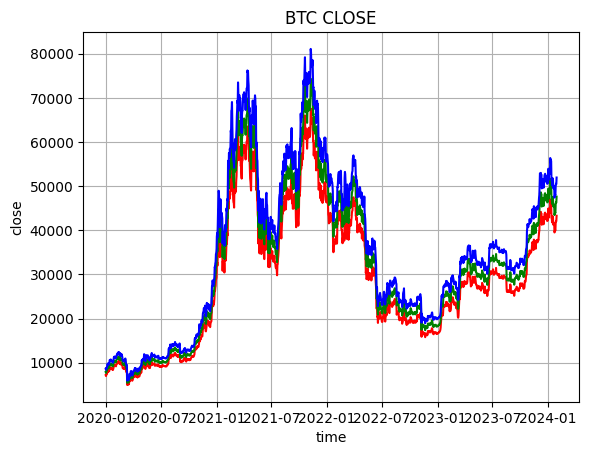

In [2]:
import matplotlib.pyplot as plt
def plot_demo(df, axs=None, just_series=False):
    """
    draw close px 
    :param axs: axs为子画布，稍后会详细讲解
    :param just_series: 是否只绘制一条收盘曲线使用series，后面会用到
    :return: 
    """
    # 如果参数传入子画布则使用子画布绘制，下一节会使用
    drawer = plt if axs is None else axs
    # Series对象tsla_df.close，红色
    drawer.plot(df.close, c='r')
    if not just_series:
        # 为曲线不重叠，y变量加了10个单位tsla_df.close.values + 10
        # numpy对象tsla_df.close.index ＋ tsla_df.close.values，绿色
        drawer.plot(df.close.index, df.close.values*1.1, c='g')
        # 为曲线不重叠，y变量加了20个单位
        # list对象，numpy.tolist()将numpy对象转换为list对象，蓝色
        drawer.plot(df.close.index.tolist(), (df.close.values*1.2).tolist(), c='b')

    plt.xlabel('time')
    plt.ylabel('close')
    plt.title('BTC CLOSE')
    plt.grid(True)

plot_demo(btc_usd_df)

### matplotlib子画布及loc的使用

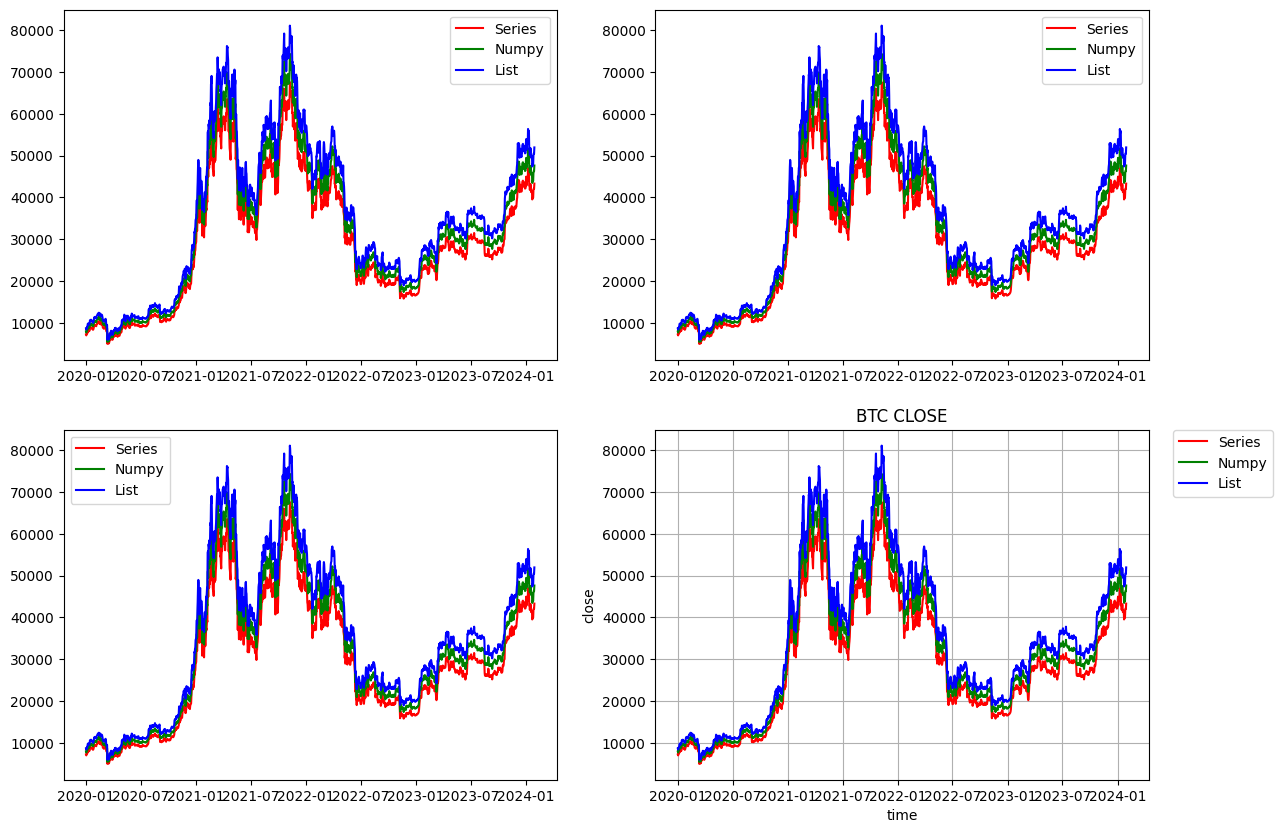

In [3]:
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
# 画布0，loc：0 plot_demo中传入画布，则使用传入的画布绘制
drawer = axs[0][0]
plot_demo(btc_usd_df, drawer)
drawer.legend(['Series', 'Numpy', 'List'], loc=0)
# 画布1，loc：1 
drawer = axs[0][1]
plot_demo(btc_usd_df, drawer)
drawer.legend(['Series', 'Numpy', 'List'], loc=1)
# 画布2，loc：2 
drawer = axs[1][0]
plot_demo(btc_usd_df, drawer)
drawer.legend(['Series', 'Numpy', 'List'], loc=2)
# 画布3，loc：2， 设置bbox_to_anchor，在画布外的相对位置绘制
drawer = axs[1][1]
plot_demo(btc_usd_df, drawer)
drawer.legend(['Series', 'Numpy', 'List'], bbox_to_anchor=(1.05, 1),
              loc=2,
              borderaxespad=0.);

# loc 一般无特殊要求，使用loc='best'指定

### 3. k线图的绘制

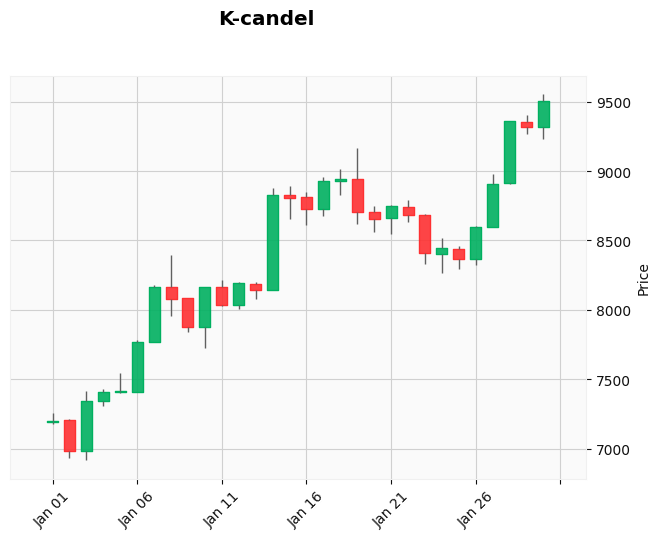

In [4]:
import mplfinance as mpf

__colorup__ = "red"
__colordown__ = "green"
# 为了示例清晰，只拿出前30天的交易数据绘制蜡烛图，
btc_part_df = btc_usd_df[:30]
mpf.plot(btc_part_df, type='candle', style='yahoo', title="K-candel", ylabel="Price")
#btc_part_df

### 如何计算风险？

In [5]:
import numpy as np
def rolling_std(list, window):
    return pd.Series(list).std() * np.sqrt(window)

data = {'value': [2,4,16,20]}
df = pd.DataFrame(data)

rolling_std = df['value'].rolling(window=3).std()*np.sqrt(3)
print(rolling_std)
#rolling_std([2,4,16],3)

0          NaN
1          NaN
2    13.114877
3    14.422205
Name: value, dtype: float64


### calculate return: return rate = np.log(df['close']/ df['close'].shift(1))

In [6]:
rolling_mean = df['value'].rolling(window=3).mean()
rolling_mean

0          NaN
1          NaN
2     7.333333
3    13.333333
Name: value, dtype: float64

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

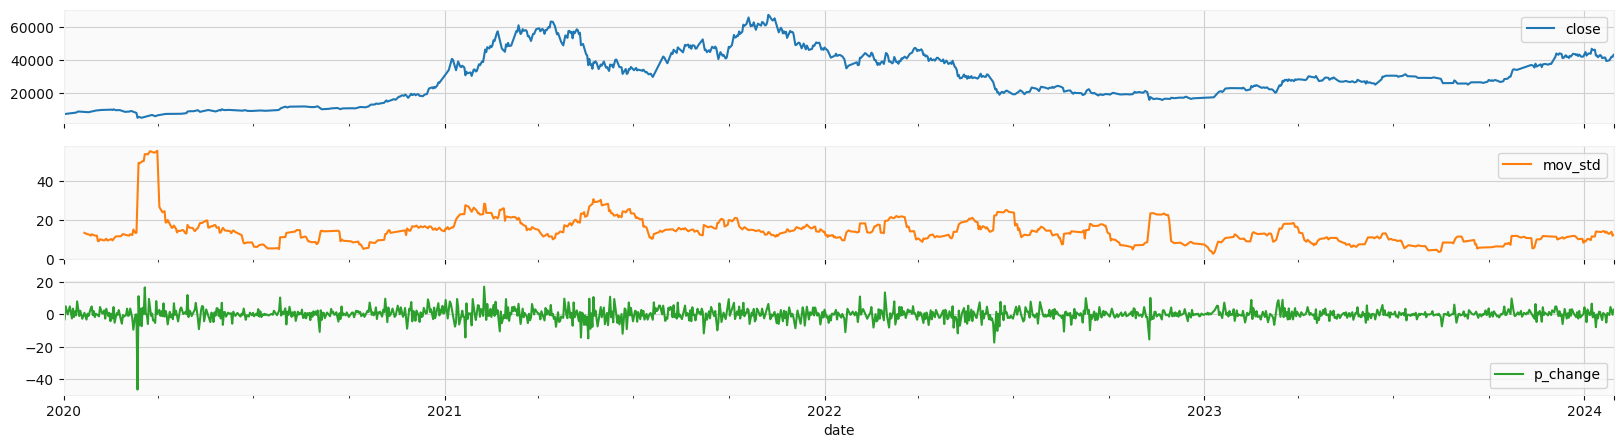

In [33]:
df = btc_usd_df.copy()
df['p_change'] = np.log(df.close/df.close.shift(1))*100
df['mov_std'] = df['p_change'].rolling(window=20).std()*np.sqrt(20)
df[['close','mov_std','p_change']].plot(figsize=(20,5), subplots=True, grid=True)

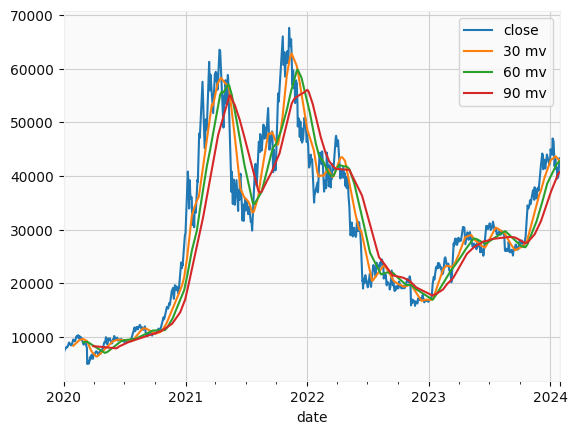

In [34]:
# draw moving average
df.close.plot()
df['close'].rolling(window=30).mean().plot()
df['close'].rolling(window=60).mean().plot()
df['close'].rolling(window=90).mean().plot()
plt.legend(['close','30 mv','60 mv', '90 mv'], loc='best')

### Strategy 1, when the open price is lower than close price, it's likely next day it will increase. 

In [9]:
low_to_high_df = df.iloc[df[(df.close > df.open) & (df.key != df.shape[0] - 1)].key.values + 1]

# iloc获取所有低开高走的下一个交易日组成low_to_high_df，由于是下一个交易日
# 所以要对满足条件的交易日再次通过iloc获取，下一个交易日index用key.values + 1

# 通过where将下一个交易日的涨跌幅通过ceil，floor向上，向下取整
change_ceil_floor = np.where(low_to_high_df['p_change'] > 0,
                             np.ceil(
                                 low_to_high_df['p_change']),
                             np.floor(
                                 low_to_high_df['p_change']))

# 使用pd.Series包裹，方便之后绘制
change_ceil_floor = pd.Series(change_ceil_floor)

低开高收的下一个交易日所有下跌的跌幅取整和sum: -1060.0
低开高收的下一个交易日所有上涨的涨幅取整和sum: 1053.0


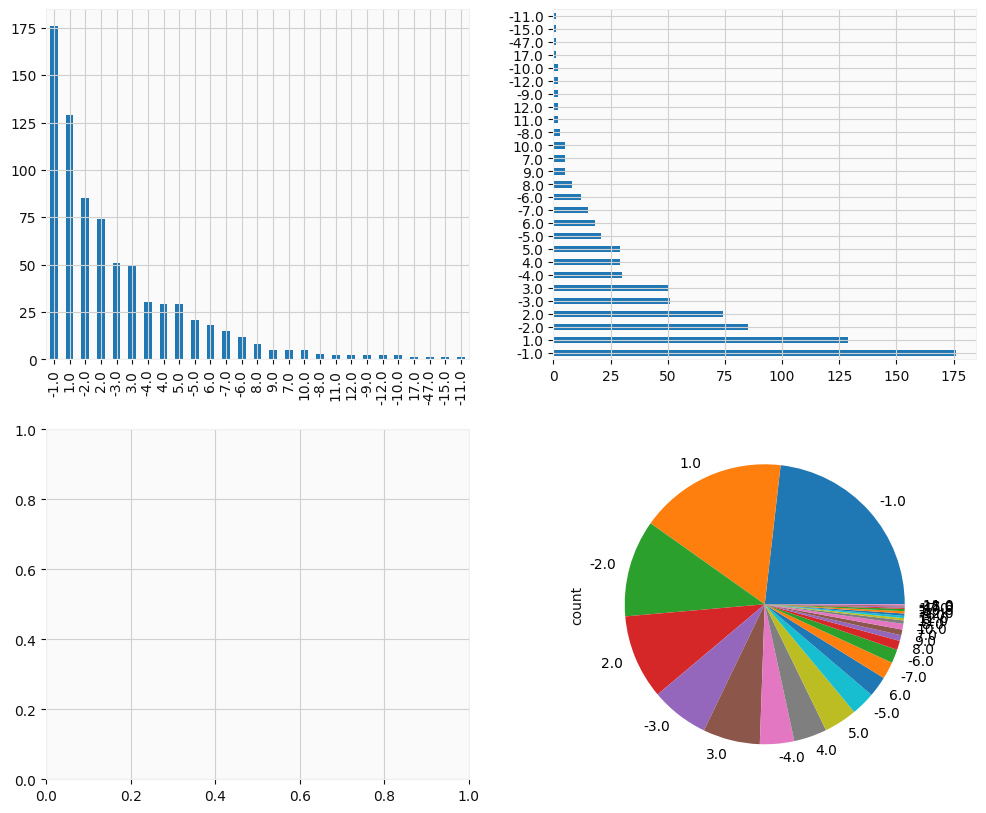

In [15]:
#import skipy
print('低开高收的下一个交易日所有下跌的跌幅取整和sum: ' + str(
change_ceil_floor[change_ceil_floor < 0].sum()))

print('低开高收的下一个交易日所有上涨的涨幅取整和sum: ' + str(
change_ceil_floor[change_ceil_floor > 0].sum()))

# 2 * 2: 四张子图
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
# 竖直柱状图，可以看到-1的柱子最高, 图5-7左上
change_ceil_floor.value_counts().plot(kind='bar', ax=axs[0][0])
# 水平柱状图，可以看到-1的柱子最长, 图5-7右上
change_ceil_floor.value_counts().plot(kind='barh', ax=axs[0][1])
# 概率密度图，可以看到向左偏移, 图5-7左下
#change_ceil_floor.value_counts().plot(kind='kde', ax=axs[1][0])
# 圆饼图，可以看到－1所占的比例最高, -2的比例也大于＋2，图5-7右下
change_ceil_floor.value_counts().plot(kind='pie', ax=axs[1][1]);

In [81]:
np.log(222.27/220.50)*100

0.7995164209774576

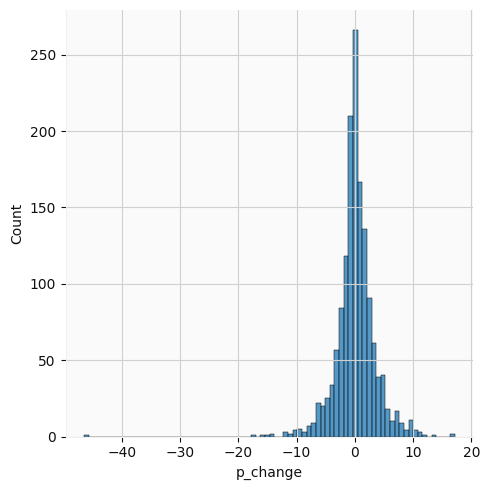

In [35]:
import seaborn as sns
sns.displot(df['p_change'], bins=80);

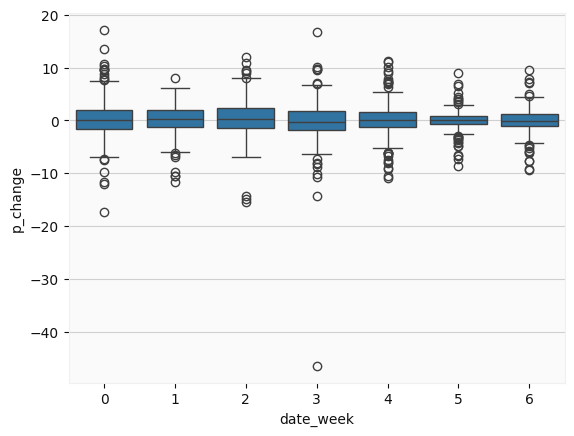

In [36]:
sns.boxplot(x='date_week', y='p_change', data=df);

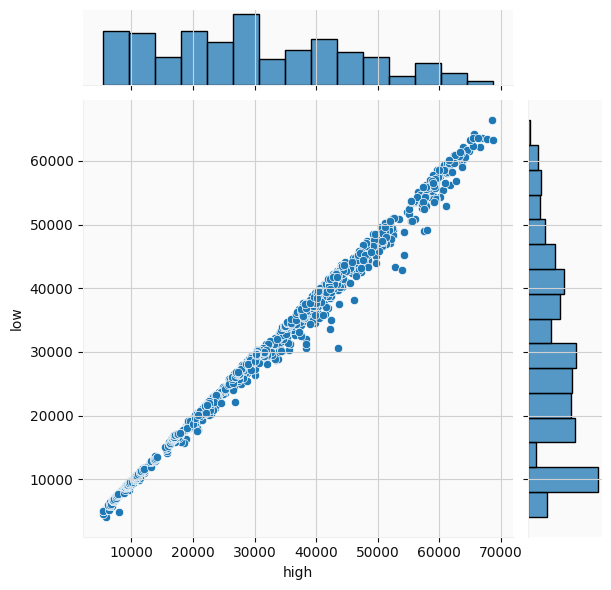

In [39]:
sns.jointplot(df, x="high", y="low");

In [ ]:
change_df = pd.DataFrame({'btc': df.p_change})
# join usGOOG
change_df = change_df.join(pd.DataFrame({'goog': ABuSymbolPd.make_kl_df('usGOOG', n_folds=2).p_change}),
                           how='outer')
# join usAAPL
change_df = change_df.join(pd.DataFrame({'aapl': ABuSymbolPd.make_kl_df('usAAPL', n_folds=2).p_change}),
                           how='outer')
# join usFB
change_df = change_df.join(pd.DataFrame({'fb': ABuSymbolPd.make_kl_df('usFB', n_folds=2).p_change}),
                           how='outer')
# join usBIDU
change_df = change_df.join(pd.DataFrame({'bidu': ABuSymbolPd.make_kl_df('usBIDU', n_folds=2).p_change}),
                           how='outer')

change_df = change_df.dropna()
# 表5-2所示
change_df.head()